In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import umap
import utils
import glob
import itertools as it
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
def compute_labels(df_train, df_store, embedding=None, iteration=0, output_dir=None, suffix=""):   
    """ Compute UMAP-DBSCAN and store clustering result. """
    # compute embedding
    if embedding is None:
        embedding = umap.UMAP(min_dist=min_dist, n_components=n_components, n_neighbors=n_neighbors).fit_transform(df_train)

    # compute clustering
    model = DBSCAN(eps=eps, min_samples=min_samples).fit(embedding)

    # drop small clusters and set their label to -1
    temp = df_store.copy()
    temp["e0"] = embedding[:, 0]
    temp["e1"] = embedding[:, 1]
    temp["e2"] = embedding[:, 2]
    temp["label"] = model.labels_
    
    # print(len(temp))
    # temp, knee, thresh = utils.drop_clusters_with_few_samples(temp, thresh=None, plotting=False)
    # print(f"      {len(temp) -len(df_store)}")

    # store output
    if output_dir:
        temp.to_csv(f"{output_dir}umap_dbscan_{iteration}{suffix}.csv", index=False)

In [3]:
def compute_overlap_matrix(a, b):
    """ Compute overlap matrix of two clusterings a and b, i.e. the number of grid cells each label combination from a and b have in common. """
    m = pd.merge(a[["LATITUDE", "LONGITUDE", "LEV_M", "label"]], 
                 b[["LATITUDE", "LONGITUDE", "LEV_M", "label"]], 
                 how="outer", 
                 on=["LATITUDE", "LONGITUDE", "LEV_M"], suffixes=["_a", "_b"])

    # count grid cells for all combinations of labels from a and b
    counts = pd.DataFrame(m[["label_a", "label_b"]].value_counts(dropna=False))
    overlap_matrix = counts["count"].unstack(fill_value=0).T.drop(np.nan, axis=1, errors="ignore").drop(np.nan, axis=0, errors="ignore")
    
    return overlap_matrix

In [4]:
def compute_overlap(a, b, overlap_matrix):
    """ Compute overlap between two clusterings a and b. Also called purity. The measure is asymmetric. """
    N_a = len(a)
    N_b = len(b)
    
    overlap_ab = 1/N_a*overlap_matrix.max(axis=0).sum()
    overlap_ba = 1/N_b*overlap_matrix.max(axis=1).sum()
    overlap = (overlap_ab + overlap_ba)/2
        
    return overlap_ab, overlap_ba, overlap

In [5]:
def compute_f_clustering_accuracy(a, b, overlap_matrix):
    """ Compute F_clustering_accuracy between two clusterings a and b. """
    N_a = len(a)
    N_b = len(b)
    N = (N_a + N_b)/2
    
    column_sum = np.array(overlap_matrix.sum(axis=0), dtype=float)
    row_sum = np.array(overlap_matrix.sum(axis=1), dtype=float)
    
    divider = np.array([column_sum] * len(row_sum)) + np.array([row_sum] * len(column_sum)).T
    factor = np.divide(1, divider, out=np.zeros(divider.shape), where=divider!=0)  # if dividing by zero, set the factor to zero instead
    f = 2 * overlap_matrix * factor
    
    fca_ab = 1/N_a * np.multiply(column_sum, f.max(axis=0)).sum()
    fca_ba = 1/N_b * np.multiply(row_sum, f.max(axis=1)).sum()
    fca = (fca_ab + fca_ba)/2
    
    return fca_ab, fca_ba, fca

In [6]:
def compute_entropies(a, b, overlap_matrix):
    """ Compute entropy measures between clustering a and b, i.e. mutual information, variation of information and normalised mutual information. """
    N_a = len(a)
    N_b = len(b)
    N = (N_a + N_b)/2

    # entropy of each partition
    h_a = -1*sum(overlap_matrix.sum(axis=0)/N_a * (overlap_matrix.sum(axis=0)/N_a).map(lambda x: np.log(x) if x != 0 else 0))
    h_b = -1*sum(overlap_matrix.sum(axis=1)/N_b * (overlap_matrix.sum(axis=1)/N_b).map(lambda x: np.log(x) if x != 0 else 0))
    
    # joint entropy
    h_ab = -1*overlap_matrix.map(lambda x: x/N * np.log(x/N) if x!= 0 else 0).sum().sum()
    
    # entropy-related measures
    mi = h_a + h_b - h_ab  # mutual information 
    vi = h_a + h_b - 2*mi  # variation of information
    nmi = mi/max(h_a, h_b)  # normalised mutual information

    return mi, vi, nmi

In [7]:
# DBSCAN hyperparameters
eps = 0.10983051  # 0.1 
min_samples = 4  # 3

# UMAP hyperparameters
min_dist = 0.0
n_components = 3
n_neighbors = 20

In [8]:
# load data
df_in = pd.read_csv("data/df_wide_knn.csv") 
df = df_in.drop(["LATITUDE", "LONGITUDE", "LEV_M"], axis=1)  # remove geolocation

# scale data
scaler = MinMaxScaler().fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

# Repeat UMAP-DBSCAN

In [9]:
output_dir_ud = "output_final/dbscan/uncertainty/UMAP_DBSCAN/"

In [10]:
num_iterations = 100

## Re-run UMAP-DBSCAN several times

In [ ]:
labels_list = []

for i in tqdm(range(num_iterations)):
    compute_labels(df_train=df_scaled, df_store=df_in, embedding=None, iteration=i, output_dir=output_dir_ud, suffix="")

## Compute dropout and scores

In [ ]:
info = []
for filename in tqdm(glob.glob(output_dir_ud + "umap_dbscan_*.csv")):
    if not "manualkneedrop" in filename:
        i = filename.split("_")[3].removesuffix(".csv")
        print(i)
        
        # load data (and compute thresh for automatic cluster-dropping)
        filename = f"umap_dbscan_{i}.csv"
        df = pd.read_csv(output_dir_ud + filename)
        # df_dropped, knee, thresh = utils.drop_clusters_with_few_samples(df, thresh=None, plotting=False)

        # load clusterings with manually dropped data
        filename_dropped = glob.glob(f"{output_dir_ud}umap_dbscan_manualkneedrop_{i}_thresh*.csv")[0]
        thresh = filename_dropped.split("thresh")[1].rstrip(".csv")
        df_dropped = pd.read_csv(filename_dropped)
        
        # compute scores only on valid labels
        temp_dropped = df_dropped[df_dropped.label != -1]  
        if len(temp_dropped["label"].unique()) > 1:
            si_dropped = silhouette_score(temp_dropped[["e0", "e1", "e2"]], temp_dropped["label"])
            db_dropped = davies_bouldin_score(temp_dropped[["e0", "e1", "e2"]], temp_dropped["label"])
            ch_dropped = calinski_harabasz_score(temp_dropped[["e0", "e1", "e2"]], temp_dropped["label"])
        else:
            si_dropped = np.nan
            db_dropped = np.nan
            ch_dropped = np.nan
    
        temp = df[df.label != -1]
        if len(temp["label"].unique()) > 1:
            si = silhouette_score(temp[["e0", "e1", "e2"]], temp["label"])
            db = davies_bouldin_score(temp[["e0", "e1", "e2"]], temp["label"])
            ch = calinski_harabasz_score(temp[["e0", "e1", "e2"]], temp["label"])
        else:
            si = np.nan
            db = np.nan
            ch = np.nan
    
        print(f"  #labels = {len(df['label'].unique())}")
        print(f"  #labels_dropped = {len(temp_dropped['label'].unique())}")
    
        # store everything
        # temp_dropped.to_csv(f"{output_dir_ud}umap_dbscan_kneedrop_{i}.csv", index=False)
        temp_dropped_info = pd.DataFrame({"filename": [f"umap_dbscan_manualkneedrop_{i}.csv"], 
                                          "thresh": [thresh], 
                                          "silhouette": [si_dropped], 
                                          "davies-bouldin": [db_dropped], 
                                          "calinski-harabasz": [ch_dropped], 
                                          "num_clusters": [len(temp_dropped.label.unique())]
                                         })
        info.append(temp_dropped_info)
    
        temp_info = pd.DataFrame({"filename": [f"umap_dbscan_{i}.csv"], 
                                  "thresh": [None], 
                                  "silhouette": [si], 
                                  "davies-bouldin": [db], 
                                  "calinski-harabasz": [ch],
                                  "num_clusters": [len(temp.label.unique())]
                                 })
        info.append(temp_info)

info = pd.concat(info)
info.to_csv(f"{output_dir_ud}info.csv", index=False)

## Inspect dropout and scores

In [12]:
info = pd.read_csv(output_dir_ud + "info.csv")
info["dropped"] = info.filename.apply(lambda x: True if "kneedrop" in x else False)

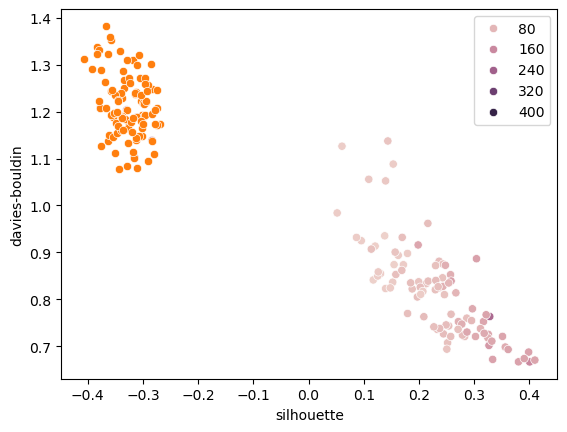

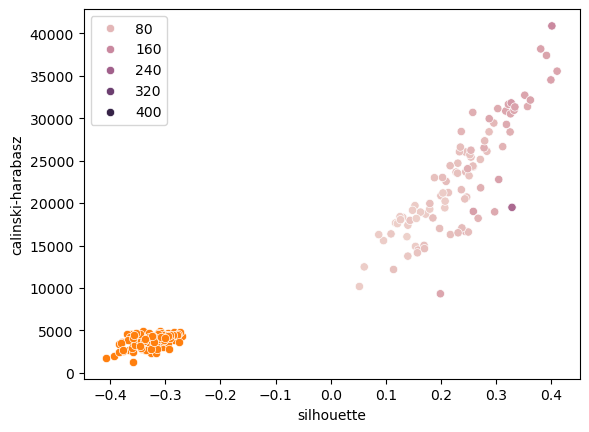

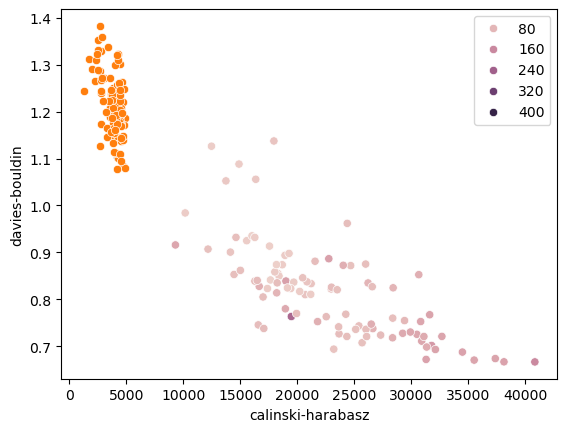

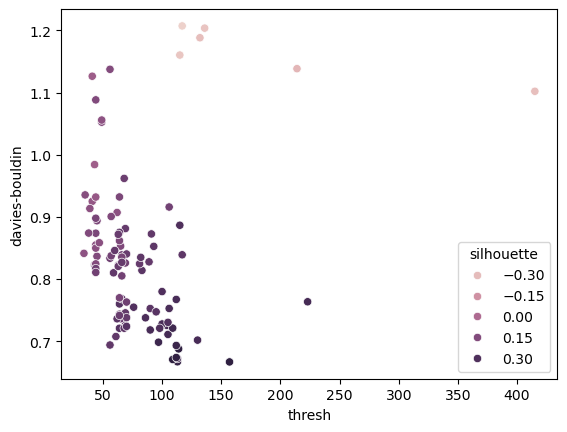

In [13]:
# compare clusterings with and without dropping of small clusters
l = info[~info.filename.str.contains("kneedrop")]
k = info[info.filename.str.contains("kneedrop")]

s0 = sns.scatterplot(data=k, x="silhouette", y="davies-bouldin", hue="thresh")
s1 = sns.scatterplot(data=l, x="silhouette", y="davies-bouldin")
plt.show()

s2 = sns.scatterplot(data=k, x="silhouette", y="calinski-harabasz", hue="thresh")
s3 = sns.scatterplot(data=l, x="silhouette", y="calinski-harabasz")
plt.show()

sns.scatterplot(data=k, x="calinski-harabasz", y="davies-bouldin", hue="thresh")
sns.scatterplot(data=l, x="calinski-harabasz", y="davies-bouldin")
plt.show()

sns.scatterplot(data=k, x="thresh", y="davies-bouldin", hue="silhouette")
plt.show()

We can see that all clusterings where clusters had been removed performed better than raw clusterings (without removal).

If we check the raw clusterings (below), we see a weak relation between the scores: Higher Silhouette entails lower Davis-Bouldin and higher Calinski-Harbasz, the correlation is between 0.3 and 0.5. Davis Bouldin is more correlated to the number of clusters than the others. 

We checked the clustering which is best according to each score (see below):
- Calinski-Harabasz: Clustering 7
- Davies-Bouldin: Clustering 13
- Silhouette: Clustering 49

In [14]:
l[['thresh', 'silhouette', 'davies-bouldin', 'calinski-harabasz', 'num_clusters']].corr()

,thresh,silhouette,davies-bouldin,calinski-harabasz,num_clusters
thresh,NaN,NaN,NaN,NaN,NaN
silhouette,NaN,1.000000,-0.269637,0.487733,0.122733
davies-bouldin,NaN,-0.269637,1.000000,-0.498311,-0.297393
calinski-harabasz,NaN,0.487733,-0.498311,1.000000,0.153590
num_clusters,NaN,0.122733,-0.297393,0.153590,1.000000


In [15]:
l.sort_values("calinski-harabasz", ascending=False)[:5]

,filename,thresh,silhouette,davies-bouldin,calinski-harabasz,num_clusters,dropped
15,umap_dbscan_7.csv,NaN,-0.339719,1.185800,4926.048735,381,False
65,umap_dbscan_32.csv,NaN,-0.310280,1.080490,4920.321729,370,False
85,umap_dbscan_42.csv,NaN,-0.284417,1.249032,4790.980564,357,False
103,umap_dbscan_51.csv,NaN,-0.273949,1.172254,4783.243179,374,False
55,umap_dbscan_27.csv,NaN,-0.329442,1.083479,4710.355302,376,False


In [16]:
l.sort_values("davies-bouldin", ascending=True)[:5]

,filename,thresh,silhouette,davies-bouldin,calinski-harabasz,num_clusters,dropped
97,umap_dbscan_48.csv,NaN,-0.343084,1.077987,4180.025574,384,False
65,umap_dbscan_32.csv,NaN,-0.310280,1.080490,4920.321729,370,False
55,umap_dbscan_27.csv,NaN,-0.329442,1.083479,4710.355302,376,False
139,umap_dbscan_69.csv,NaN,-0.290811,1.095876,4515.149282,404,False
5,umap_dbscan_2.csv,NaN,-0.315492,1.102135,4266.752286,392,False


In [17]:
l.sort_values("silhouette", ascending=False)[:5]

,filename,thresh,silhouette,davies-bouldin,calinski-harabasz,num_clusters,dropped
99,umap_dbscan_49.csv,NaN,-0.270113,1.172741,4350.671676,383,False
21,umap_dbscan_10.csv,NaN,-0.273876,1.208419,4542.483331,376,False
103,umap_dbscan_51.csv,NaN,-0.273949,1.172254,4783.243179,374,False
177,umap_dbscan_88.csv,NaN,-0.274374,1.246386,3674.014637,387,False
111,umap_dbscan_55.csv,NaN,-0.277820,1.173898,4527.522608,381,False


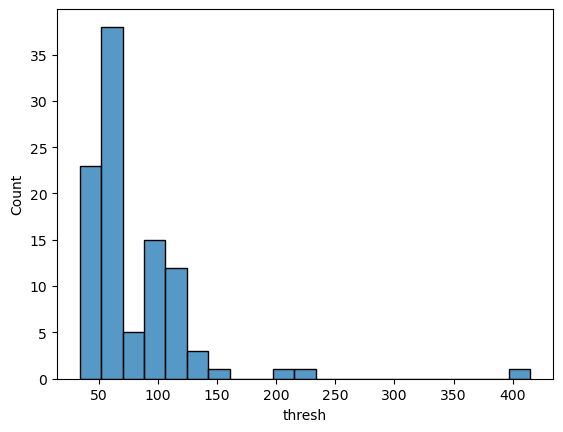

In [18]:
sns.histplot(info.thresh)
plt.show()

## Uncertainty

In [ ]:
# compute uncertainty measures
df_res = []

# iterate over each pair of clusterings
for i in tqdm(range(num_iterations), desc=""):
    for j in range(num_iterations):
        if j<i: 
            # load clusterings
            clustering_a = pd.read_csv(f"{output_dir}umap_dbscan_{i}.csv")
            clustering_b = pd.read_csv(f"{output_dir}umap_dbscan_{j}.csv")
            
            # ignore noise cluster
            clustering_a = clustering_a[clustering_a.label != -1]
            clustering_b = clustering_b[clustering_b.label != -1]

            # compute overlap matrix
            overlap_matrix = compute_overlap_matrix(a=clustering_a, b=clustering_b)
            
            # compute overlap
            overlap_ab, overlap_ba, symmetric_overlap = compute_overlap(a=clustering_a, b=clustering_b, overlap_matrix=overlap_matrix)
            fca_ab, fca_ba, fca = compute_f_clustering_accuracy(clustering_a, clustering_b, overlap_matrix)
            mi, vi, nmi = compute_entropies(clustering_a, clustering_b, overlap_matrix)
            df_res.append(pd.DataFrame({"clustering_a": [i], "clustering_b": [j], 
                                        "overlap_ab": [overlap_ab], "overlap_ba": [overlap_ba], "overlap": [symmetric_overlap],
                                        "f_accuracy_ab": [fca_ab], "f_accuracy_ba": [fca_ba], "f_accuracy": [fca], 
                                        "mutual_infomration": [mi], "variation_of_information": [vi], "normalized_mutual_information": [nmi]
                                       }))

df_res = pd.concat(df_res)
df_res.to_csv(output_dir_ud + "uncertainty_scores.csv")

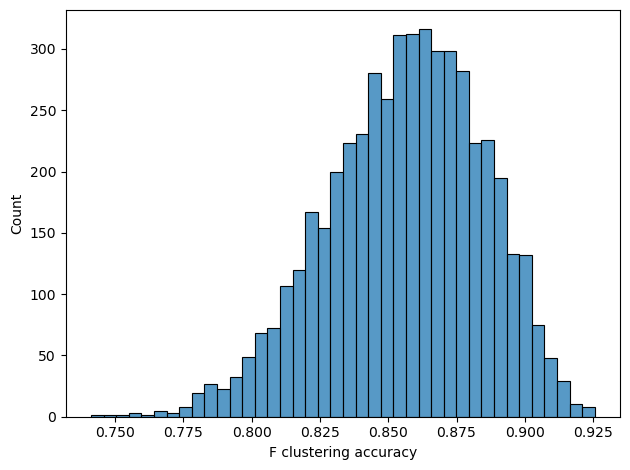

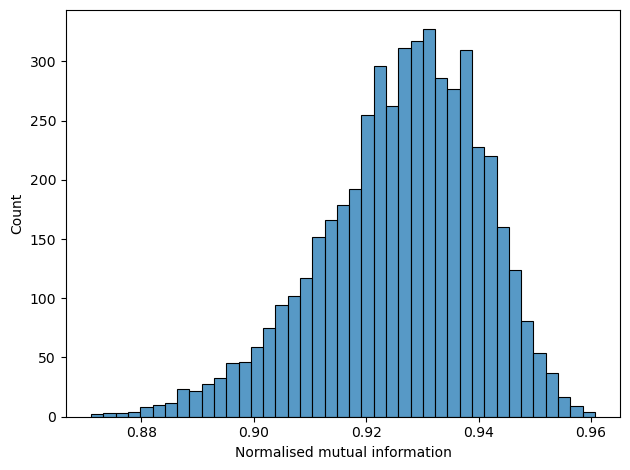

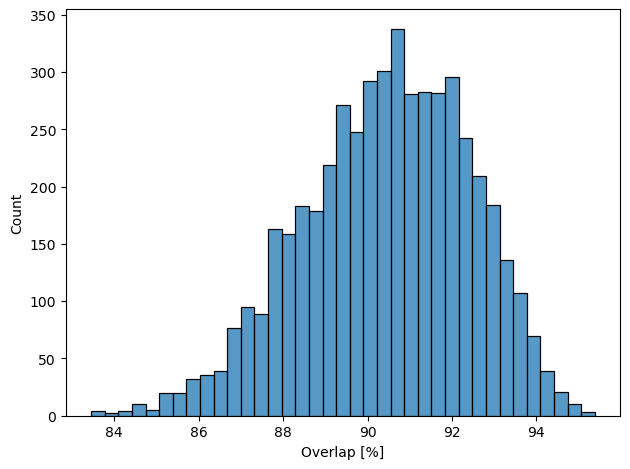

In [129]:
# plot uncertainties
df_res = pd.read_csv(output_dir_ud + "uncertainty_scores.csv")  # load uncertainty results

sns.histplot(df_res.f_accuracy)
plt.xlabel("F clustering accuracy")
# plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.tight_layout()
plt.savefig(output_dir_ud + "f_clustering_accuracy.png")
plt.show()

sns.histplot(df_res.normalized_mutual_information)
plt.xlabel("Normalised mutual information")
# plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.tight_layout()
plt.savefig(output_dir_ud + "normalised_mutual_information.png")
plt.show()

sns.histplot(df_res.overlap*100)
plt.xlabel("Overlap [%]")
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.tight_layout()
plt.savefig(output_dir_ud + "overlap.png")
plt.show()

In [20]:
print(f" We have a mean overlap of {df_res.overlap.mean()*100} +- {df_res.overlap.std()*100} %")

 We have a mean overlap of 90.43580268837206 +- 1.9815187052784486 %


## Uncertainty through cluster matching

In [ ]:
## hmm maybe this is too uncertain?

### Step 1: Find maximum overlapping labels/clusters for each combination of clustering 

In [ ]:
# compare outputs matching by #overlapping samples
# num_iterations = len(res)
res_matching = []
for i in tqdm(range(num_iterations)):
    for j in range(num_iterations):
        if i != j:
            # load both label sets
            a = pd.read_csv(f"{output_dir_ud}umap_dbscan_{i}.csv")
            b = pd.read_csv(f"{output_dir_ud}umap_dbscan_{j}.csv")
            # a = pd.DataFrame(labels_list[i], columns=["label"])  # pd.read_csv(output_dir_ud + f"eps_{eps}-min_samples_{min_samples}-iteration_{i}.csv")
            # b = pd.DataFrame(labels_list[j], columns=["label"])  # pd.read_csv(output_dir_ud + f"eps_{eps}-min_samples_{min_samples}-iteration_{j}.csv")

            # compute number of clusters of both clusterings
            num_clusters_a = len(a['label'].unique())
            num_clusters_b = len(b['label'].unique())
            print(f"Number of clusters difference: {num_clusters_a - num_clusters_b}")

            # compare num samples per cluster
            num_samples_a = pd.DataFrame(a.value_counts()).reset_index()
            num_samples_b = pd.DataFrame(b.value_counts()).reset_index()

            # match clusters by computing sample overlap
            df_labels = a.copy()
            df_labels = df_labels.rename(columns={"label": "label_a"})
            df_labels = df_labels.merge(b[["LATITUDE", "LONGITUDE", "LEV_M", "label"]].rename(columns={"label": "label_b"}), how="outer", on=["LATITUDE", "LONGITUDE", "LEV_M"])
            # df_labels["label_a"] = a
            # df_labels["label_b"] = b

            # iterate over each cluster in a
            for c in np.sort(a["label"].unique()):
                # check potential matches (given label c (from clusterin a), which labels in clustering b are at the same points?
                matches = pd.DataFrame(df_labels[df_labels["label_a"] == c]["label_b"])
                match_counts = matches.value_counts().reset_index()
                num_matches = len(match_counts)

                # what is the cluster in b, that has most points in common with cluster c (from clustering a)?
                max_match = match_counts[match_counts["count"] == match_counts["count"].max()]

                # if all samples in c got assigned the same cluster in b, num_matches will be 1
                if num_matches != 0:
                    res_matching.append({"clustering_a": i, "clustering_b": j,
                                "label_a": c,
                                "label_b": max_match["label_b"].values[0],
                                "num_samples_a": len(matches),
                                "num_samples_max_match": max_match["count"].values[0],
                                "difference": len(matches) - max_match["count"].values[0]})
                else:
                    # if no matching cluster was found
                    res_matching.append({"clustering_a": i, "clustering_b": j,
                                "label_a": c,
                                "label_b": np.nan,
                                "num_samples_a": len(matches),
                                "num_samples_max_match": np.nan,
                                "difference": np.nan})

In [ ]:
df_overlap = pd.DataFrame(res_matching)
df_overlap.to_csv(f"{output_dir_ud}overlap_withoutDrop.csv", index=False)

### Step 2: Apply the label mapping, count the number of different labels, compute uncertainties

In [ ]:
df_overlap = pd.read_csv(f"{output_dir_ud}overlap_withoutDrop.csv")

In [ ]:
uncertainty = df_in.copy()
uncertainty["uncertainty"] = 0

for i in tqdm(range(num_iterations)):
    for j in range(num_iterations):
        if j<i: 
            df_clustering_a = pd.read_csv(f"{output_dir_ud}umap_dbscan_{i}.csv").rename(columns={"label": "label_a"})
            df_clustering_b = pd.read_csv(f"{output_dir_ud}umap_dbscan_{j}.csv").rename(columns={"label": "label_b"})
    
            temp = df_clustering_a.copy()
            temp = temp.merge(df_clustering_b[["LATITUDE", "LONGITUDE", "LEV_M", "label_b"]], how="outer", on=["LATITUDE", "LONGITUDE", "LEV_M"])
    
            # define mapping between clustering a and by
            # we always need to start from clustering a (as this is how we have done the prvious computation step)
            mapping_a_b = df_overlap[(df_overlap.clustering_a == i) & (df_overlap.clustering_b == j)][["label_a", "label_b"]]
            # mapping_b_a = df_overlap[(df_overlap.clustering_a == j) & (df_overlap.clustering_b == i)][["label_a", "label_b"]]

            # map labes from clustering a to labels from clustering b (and vice versa)
            # temp["label_a_mapped"] = temp["label_a"].apply(lambda x: mapping_a_b[mapping_a_b.label_a.astype(float).astype(str) == str(float(x))].iloc[0].label_b)  # this is the label mapping
            # temp["label_b_mapped"] = temp["label_b"].apply(lambda x: mapping_b_a[mapping_b_a.label_b.astype(float).astype(str) == str(float(x))].iloc[0].label_a)  # this is the label mapping
            temp = pd.merge(left=temp, right=mapping_a_b, how="left", on="label_a", suffixes=("", "_mapped")).rename(columns={"label_b_mapped": "label_a_mapped"})

            # uncertainty of clustering for given 2 clusterings
            temp["are_labels_unequal_ab"] = temp.label_a_mapped != temp.label_b
            temp["cur_uncertainty"] = temp["are_labels_unequal_ab"].astype(int)
            # temp["cur_uncertainty_ab"] = temp["are_labels_unequal_ab"].astype(int) 

            # temp["are_labels_unequal_ba"] = temp.label_b_mapped != temp.label_a
            # temp["cur_uncertainty_ba"] = temp["are_labels_unequal_ba"].astype(int) 

            # @todo in the previous step, we are just matching labels a-b (not b-a) - so we cannot compute the b-a matching here. would be nice to increase precision of our uncertainty estimate
            # # decide which uncertainty is worse a-b or b-a and choose it (take worst case uncertainty)
            # if temp["cur_uncertainty_ab"].sum() > temp["cur_uncertainty_ba"].sum():
            #     temp["cur_uncertainty"] = temp["cur_uncertainty_ab"]
            # else:
            #     temp["cur_uncertainty"] = temp["cur_uncertainty_ba"]

            # update overall uncertainty
            uncertainty = uncertainty.merge(temp[["LATITUDE", "LONGITUDE", "LEV_M", "cur_uncertainty"]], how="outer", on=["LATITUDE", "LONGITUDE", "LEV_M"])
            uncertainty["uncertainty"] = uncertainty["uncertainty"] + uncertainty["cur_uncertainty"]
            uncertainty = uncertainty.drop("cur_uncertainty", axis=1)

uncertainty["uncertainty"] = uncertainty["uncertainty"]/(num_iterations*(num_iterations-1)/2)*100

# add UMAP coordinates from last clustering
uncertainty = pd.merge(uncertainty, df_clustering_a[["LATITUDE", "LONGITUDE", "LEV_M", "e0", "e1", "e2"]], how="left", on=["LATITUDE", "LONGITUDE", "LEV_M"])

In [ ]:
uncertainty.to_csv(f"{output_dir_ud}uncertainty.csv", index=False)

### Plot matching uncertainties

In [21]:
uncertainty = pd.read_csv(f"{output_dir_ud}uncertainty.csv")

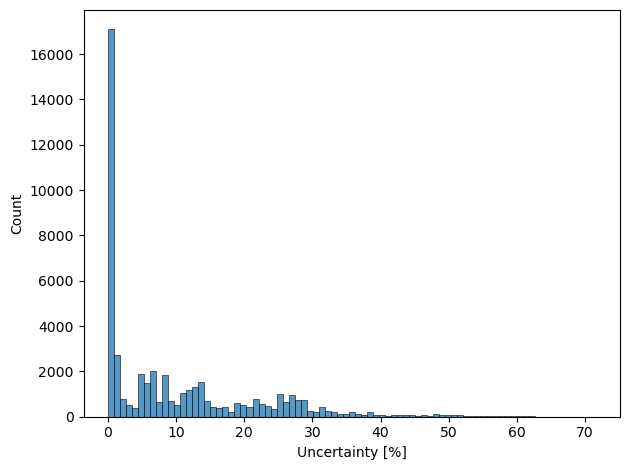

In [22]:
sns.histplot(uncertainty["uncertainty"]) # many uncertain points...
plt.xlabel("Uncertainty [%]")
plt.tight_layout()
plt.savefig(f"{output_dir_ud}uncertainty_withDrop_histplot.png")
plt.show()

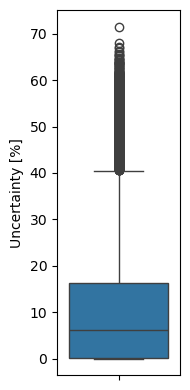

In [23]:
fig = plt.figure(figsize=(2, 4))
sns.boxplot(uncertainty["uncertainty"]) # many uncertain points...
plt.ylabel("Uncertainty [%]")
plt.tight_layout()
plt.savefig(f"{output_dir_ud}uncertainty_withDrop_boxplot.png")
plt.show()

In [24]:
print(f"Average uncertainty: {round(uncertainty.uncertainty.mean(), 2)} +- {round(uncertainty.uncertainty.std(), 2)} %")

Average uncertainty: 10.16 +- 12.14 %


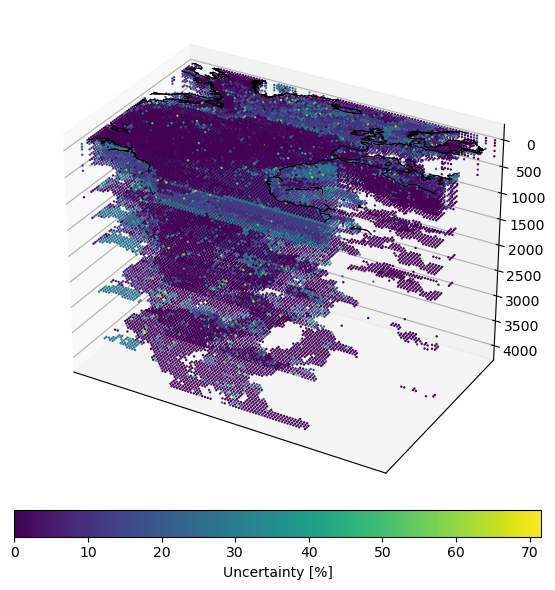

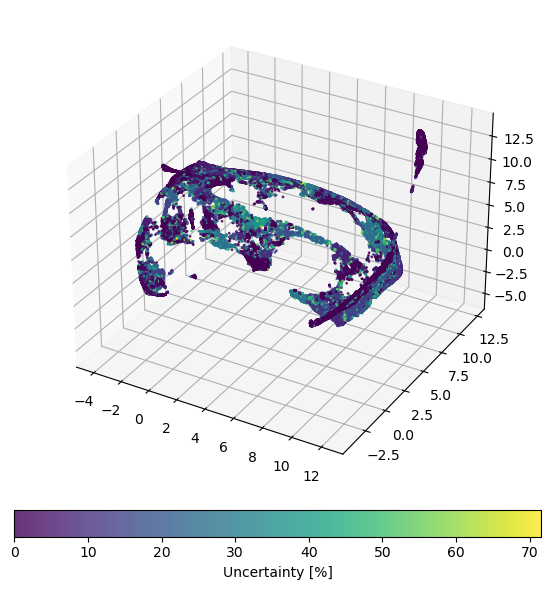

In [25]:
# define Basemap
mymap = Basemap(llcrnrlon=uncertainty["LONGITUDE"].min(), llcrnrlat=uncertainty["LATITUDE"].min(), 
                urcrnrlon=uncertainty["LONGITUDE"].max(), urcrnrlat=uncertainty["LATITUDE"].max(), fix_aspect=False)

# plot
figsize = (6, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')
sc_3d = ax.scatter(uncertainty["LONGITUDE"], uncertainty["LATITUDE"], uncertainty["LEV_M"], c=uncertainty["uncertainty"], s=0.5, alpha=1, zorder=4)  # df["predictions"]
ax.add_collection3d(mymap.drawcoastlines(linewidth=0.5))
ax.set_box_aspect((np.ptp(uncertainty["LONGITUDE"]), np.ptp(uncertainty["LATITUDE"]), np.ptp(uncertainty["LEV_M"])/50))  # aspect ratio is 1:1:1 in data space
plt.gca().invert_zaxis()
plt.colorbar(sc_3d, location="bottom", fraction=0.05, pad=0.01, label="Uncertainty [%]")
plt.tight_layout()
plt.savefig(f"{output_dir_ud}uncertainty_withDrop_geospace.png")
plt.show()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')
sc_umap = ax.scatter(uncertainty["e0"], uncertainty["e1"], uncertainty["e2"], c=uncertainty["uncertainty"], alpha=0.8, zorder=4, s=1)  # , s=s, alpha=1, zorder=4)
plt.colorbar(sc_umap, location="bottom", fraction=0.05, pad=0.05, label="Uncertainty [%]")
plt.tight_layout()
plt.savefig(f"{output_dir_ud}uncertainty_withDrop_umapspace.png")
plt.show()

# Repeat DBSCAN (fixed UMAP)

In [26]:
num_iterations = 100

In [27]:
output_dir_d = "output_final/dbscan/uncertainty/fixed_UMAP/"

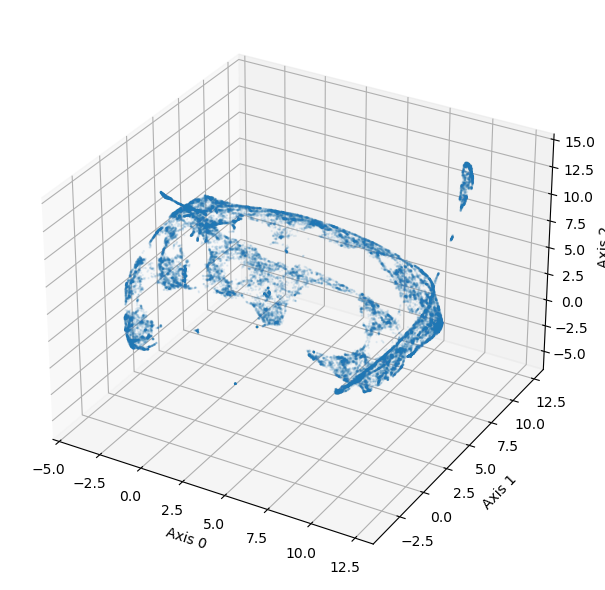

In [28]:
# compute fixed embedding
embedding = umap.UMAP(min_dist=min_dist, n_components=n_components, n_neighbors=n_neighbors).fit_transform(df_scaled)
utils.plot_embedding(embedding)

## Re-run DBSCAN several times

In [ ]:
# have training data (scaled data) and embedding in one df (needed for shuffling later on)
df_fixedUMAP = df_scaled.copy()
df_fixedUMAP["e0"] = embedding[:, 0]
df_fixedUMAP["e1"] = embedding[:, 1]
df_fixedUMAP["e2"] = embedding[:, 2]

In [ ]:
labels_list = []

for i in tqdm(range(num_iterations)):
    # shuffling data (shuffling needed since DBSCAN is only sensitive to sequence of input)
    idx = np.random.permutation(df_in.index)
    temp_df_fixedUMAP = df_fixedUMAP.reindex(idx)
    temp_df_in = df_in.reindex(idx)

    # compute DBSCAN on given embedding
    compute_labels(df_train=temp_df_fixedUMAP[df_scaled.columns], 
                   df_store=temp_df_in, 
                   embedding=temp_df_fixedUMAP[["e0", "e1", "e2"]].to_numpy(), 
                   iteration=i, output_dir=output_dir_d, suffix="_fixedUMAP")

## Uncertainty

In [ ]:
# compute uncertainty measures
df_res = []

# iterate over each pair of clusterings
for i in tqdm(range(num_iterations), desc=""):
    for j in range(num_iterations):
        if j<i: 
            # load clusterings
            clustering_a = pd.read_csv(f"{output_dir_d}umap_dbscan_{i}_fixedUMAP.csv")
            clustering_b = pd.read_csv(f"{output_dir_d}umap_dbscan_{j}_fixedUMAP.csv")
            
            # ignore noise cluster
            clustering_a = clustering_a[clustering_a.label != -1]
            clustering_b = clustering_b[clustering_b.label != -1]

            # compute overlap matrix
            overlap_matrix = compute_overlap_matrix(a=clustering_a, b=clustering_b)
            
            # compute overlap
            overlap_ab, overlap_ba, symmetric_overlap = compute_overlap(a=clustering_a, b=clustering_b, overlap_matrix=overlap_matrix)
            fca_ab, fca_ba, fca = compute_f_clustering_accuracy(clustering_a, clustering_b, overlap_matrix)
            mi, vi, nmi = compute_entropies(clustering_a, clustering_b, overlap_matrix)
            df_res.append(pd.DataFrame({"clustering_a": [i], "clustering_b": [j], 
                                        "overlap_ab": [overlap_ab], "overlap_ba": [overlap_ba], "overlap": [symmetric_overlap],
                                        "f_accuracy_ab": [fca_ab], "f_accuracy_ba": [fca_ba], "f_accuracy": [fca], 
                                        "mutual_infomration": [mi], "variation_of_information": [vi], "normalized_mutual_information": [nmi]
                                       }))

df_res = pd.concat(df_res)
df_res.to_csv(output_dir_d + "uncertainty_scores.csv", index=False)

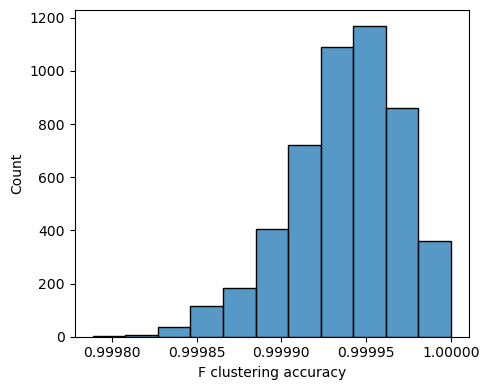

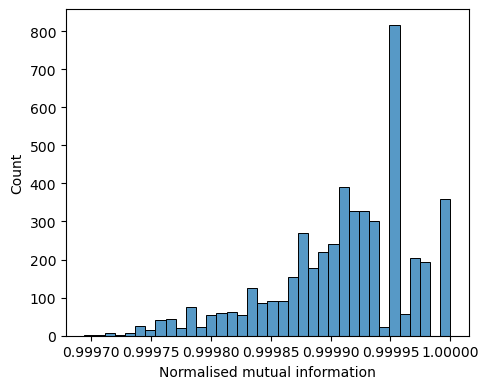

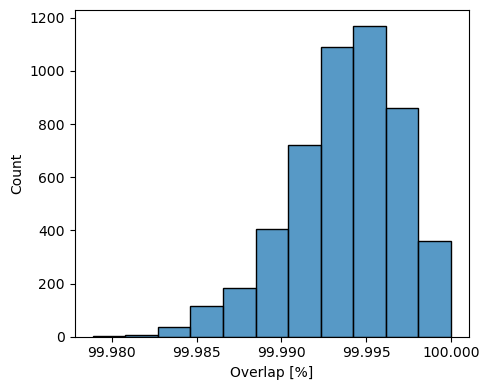

In [121]:
# plot uncertainties
df_res = pd.read_csv(output_dir_d + "uncertainty_scores.csv") # load uncertainty results

figsize = (5, 4)

fig = plt.figure(figsize=figsize)
sns.histplot(df_res.f_accuracy, bins=11)
plt.xlabel("F clustering accuracy")
# plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.tight_layout()
plt.savefig(output_dir_d + "f_clustering_accuracy_fixedUMAP.png")
plt.show()

fig = plt.figure(figsize=figsize)
sns.histplot(df_res.normalized_mutual_information)
plt.xlabel("Normalised mutual information")
# plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.tight_layout()
plt.savefig(output_dir_d + "normalised_mutual_information_fixedUMAP.png")
plt.show()

fig = plt.figure(figsize=figsize)
sns.histplot(df_res.overlap*100, bins=11)
plt.xlabel("Overlap [%]")
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.tight_layout()
plt.savefig(output_dir_d + "overlap_fixedUMAP.png")
plt.show()

In [30]:
print(f" We have a mean overlap of {df_res.overlap.mean()*100} +- {df_res.overlap.std()*100} %")

 We have a mean overlap of 99.99416668855065 +- 0.003635056059703529 %
